# Elo Merchant Category Recommendation
Help understand customer loyalty

![image](https://storage.googleapis.com/kaggle-competitions/kaggle/10445/logos/thumb76_76.png?t=2018-10-24-17-14-05)

### Description
Imagine being hungry in an unfamiliar part of town and getting restaurant recommendations served up, based on your personal preferences, at just the right moment. The recommendation comes with an attached discount from your credit card provider for a local place around the corner!

Right now, Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? Personalization is key.

Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. But so far none of them is specifically tailored for an individual or profile. This is where you come in.

* **In this competition, Kagglers will develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty.**
* **Your input will improve customers’ lives and help Elo reduce unwanted campaigns, to create the right experience for customers.**


### File descriptions
* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format - contains all card_ids you are expected to predict for.
* historical_transactions.csv - up to 3 months' worth of historical transactions for each card_id
* merchants.csv - additional information about all merchants / merchant_ids in the dataset.
* new_merchant_transactions.csv - two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data.


### What should I expect the data format to be?
The data is formatted as follows:

* train.csv and test.csv contain card_ids and information about the card itself - the first month the card was active, etc. train.csv also contains the target.
* historical_transactions.csv and new_merchant_transactions.csv are designed to be joined with train.csv, test.csv, and merchants.csv. They contain information about transactions for each card, as described above.
* merchants can be joined with the transaction sets to provide additional merchant-level information.


In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#### Dataset 파악을 위해 기본적으로 사용할 함수를 정의.

In [73]:
# 칼럼별 null 갯수 확인하기
def print_num_nulls_by_column(df):
    
    for colname in df.columns:
        numnulls = df[colname].isnull().sum()
        if numnulls:
            print(colname, 'num of nulls:', numnulls)
            print(colname, 'num of nulls / total entries:', numnulls/(df.size/len(df.columns)))

In [74]:
# 칼럼별 unique value 갯수 확인하기
# unique value를 출력하기 위한 조건 지정 가능 (ex. unique value 10개 이하일 때, 전체 리스트 출력)

def print_num_uniques_by_column(df, threshold=0):
    
    for colname in df.columns:
        uniques = df[colname].unique()
        num_uniques = len(uniques)
        
        print(colname, 'num of uniques :', num_uniques)
        
        if threshold and (num_uniques <= threshold):
            print(colname, 'list of uniques :')
            print(uniques)

In [7]:
train = pd.read_csv('data/train.csv')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [8]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


## Investigating `train.csv`
201916 entires // non-null dataset.

* card_id - 데이터셋 내 중복 없는 유니크 값
  * 모든 값은 공통적으로 `C_ID_` 문자열로 시작 (ex. `C_ID_92a2005557`)
* feature_1 - 1,2,3,4,5 카테고리 값
* feature_2 - 1,2,3 카테고리 값
* feature_3 - 0,1 카테고리 값
* target - 평균 -0.4, 표준편차 3.85, 최소값 -33.22, 최대값 17.97을 갖는 실수값

In [20]:
# 
len(train['card_id'].unique())

201917

In [34]:
for id_ in train['card_id']:
    if not id_.startswith('C_ID_'):
        print('-----------')

In [22]:
print(train['feature_1'].unique())
print(train['feature_2'].unique())
print(train['feature_3'].unique())

[5 4 2 1 3]
[2 1 3]
[1 0]


#### `feature_{}` 변수와 `target` 목표변수 간의 선형성 또는 관계성을 시각화를 통해 파악하기
* 선형성이 존재하지 않음 - `feature_{}` 값은 카테고리 변수로 파악됨.
* 카테고리 변수 - target 변수 간 시각화를 통해 확인한 것
  * **각 카테고리 값은 개별적으로는 target variable과 상관성이 두드러지게 나타나지 않음**

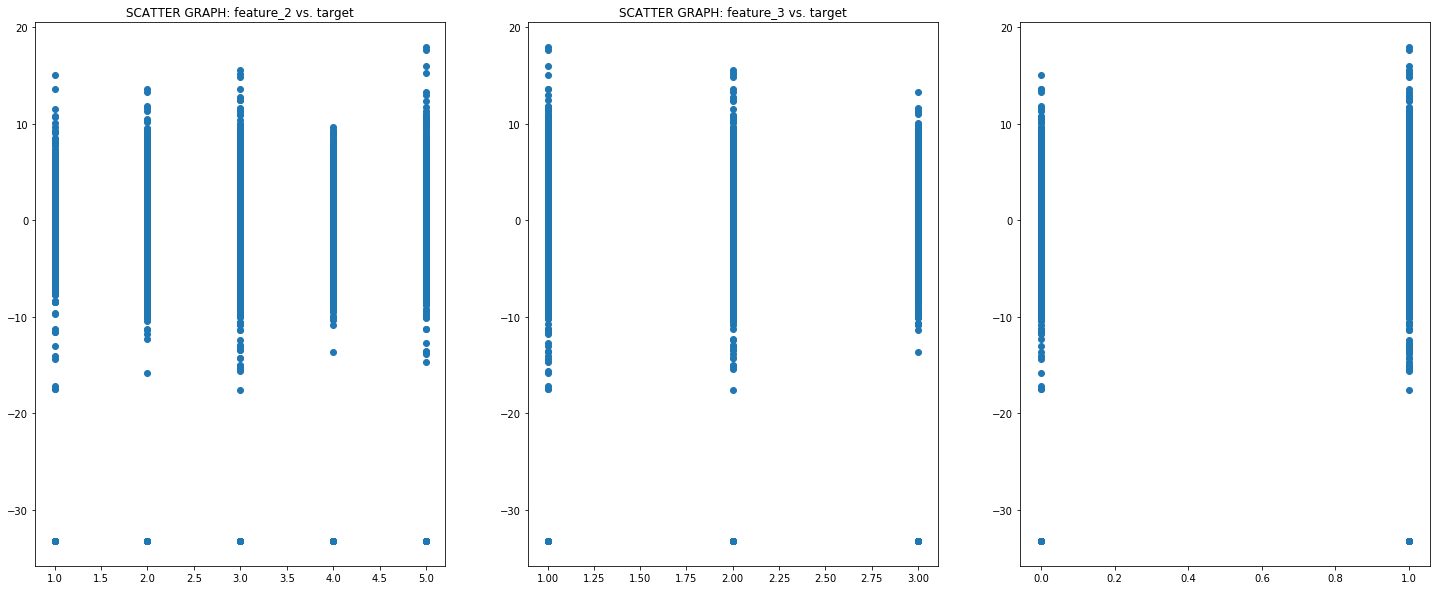

In [43]:
plt.figure(figsize=(25,10))

for i in range(1,4):

    plt.title('SCATTER GRAPH: feature_'+str(i)+' vs. target')
    plt.subplot(1,3,i)
    plt.scatter(train['feature_'+str(i)], train['target'])
    
plt.show()

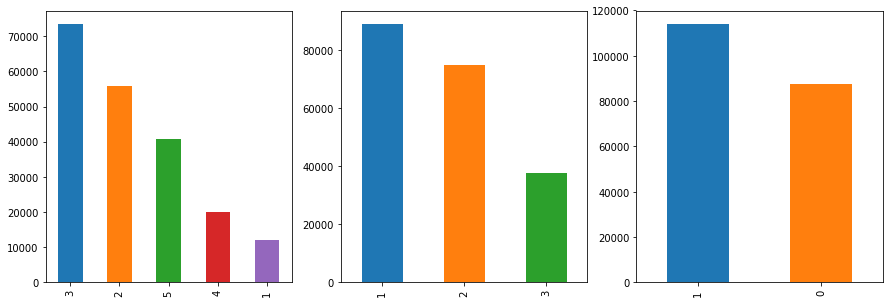

In [89]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
train['feature_1'].value_counts().plot(kind='bar')
plt.subplot(1,3,2)
train['feature_2'].value_counts().plot(kind='bar')
plt.subplot(1,3,3)
train['feature_3'].value_counts().plot(kind='bar')
plt.show()

In [31]:
print(pd.DataFrame(train['target']).describe())

              target
count  201917.000000
mean       -0.393636
std         3.850500
min       -33.219281
25%        -0.883110
50%        -0.023437
75%         0.765453
max        17.965068


## Investigating `historical_transactions.csv` dataset
* 

In [12]:
history = pd.read_csv('data/historical_transactions.csv')

In [16]:
# 29112361 entries - this dataset needs to be memory-optimized.
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [15]:
history.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


#### 전체 dataset 중 가장 큰 용량을 차지하고 있으며, 이후 분석 작업의 효율을 위하여 memory optimization 진행

In [49]:
pd.DataFrame(history['city_id']).memory_usage(deep=1)

Index             80
city_id    232898888
dtype: int64

In [44]:
history['city_id'].min(), history['city_id'].max()

(-1, 347)

In [50]:
history['city_id'] = pd.to_numeric(history['city_id'], downcast='integer')
history['city_id'].memory_usage(deep=1) # 232898888 -> 58224802 약 1/4 수준으로 메모리 사용 최적화.

58224802

In [ ]:
# integer 값을 갖는 변수 전체 최적화

In [54]:
history['city_id'].dtype == 'int16'

True

In [55]:
history_integer_colnames, history_float_colnames = [], []

for colname in history.columns:
    
    if history[colname].dtype == 'int64':
        history_integer_colnames.append(colname)
    
    if history[colname].dtype == 'float64':
        history_float_colnames.append(colname)

In [56]:
for intcol in history_integer_colnames:
    history[intcol] = pd.to_numeric(history[intcol], downcast='integer')
    
for floatcol in history_float_colnames:
    history[floatcol] = pd.to_numeric(history[floatcol], downcast='float')

In [60]:
# 메모리 사용량 3.0GB+ -> 1.8+GB, 기존 사용량 대비 60% 수준으로 최적화
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int16
category_1              object
installments            int16
category_3              object
merchant_category_id    int16
merchant_id             object
month_lag               int8
purchase_amount         float32
purchase_date           object
category_2              float32
state_id                int8
subsector_id            int8
dtypes: float32(2), int16(3), int8(3), object(6)
memory usage: 1.8+ GB


In [71]:
# 개별 변수의 null 갯수 확인 (존재할 경우, null 갯수 및 전체 entiry 갯수 대비 비중 출력.)
# category_3, merchant_id, category_2 세 개의 변수에서 null값이 확인되었으며,
# category_3, merchant_id는 전체의 1% 미만, category_2는 전체의 9% 수준으로 null 비중이 높음

In [75]:
print_num_nulls_by_column(history)

category_3 num of nulls: 178159
category_3 num of nulls / total entries: 0.00611970289871
merchant_id num of nulls: 138481
merchant_id num of nulls / total entries: 0.00475677668328
category_2 num of nulls: 2652864
category_2 num of nulls / total entries: 0.0911250035681


In [ ]:
# 개별 변수의 unique value 갯수 확인 (10개 미만일 경우 전체 리스트 출력)

In [77]:
print_num_uniques_by_column(history, 10)

authorized_flag num of uniques : 2
authorized_flag list of uniques :
['Y' 'N']
card_id num of uniques : 325540
city_id num of uniques : 308
category_1 num of uniques : 2
category_1 list of uniques :
['N' 'Y']
installments num of uniques : 15
category_3 num of uniques : 4
category_3 list of uniques :
['A' 'B' 'C' nan]
merchant_category_id num of uniques : 327
merchant_id num of uniques : 326312
month_lag num of uniques : 14
purchase_amount num of uniques : 215014
purchase_date num of uniques : 16395300
category_2 num of uniques : 6
category_2 list of uniques :
[  1.  nan   3.   5.   2.   4.]
state_id num of uniques : 25
subsector_id num of uniques : 41


### `authorized_flag` 변수
* 2개의 binary class 변수
* 결제 미승인 건은 승인건수의 약 10% 수준

#### 2개의 라벨을 갖는 카테고리 변수로 활용 가능할 것으로 판단됨
* 이것 자체로도 활용이 가능하나, 개별 `card_id`의 승인/미승인 비율 또는 개별 `merchant_id`의 승인/미승인 비율 변수로 engineering 가능할 것으로 보임

In [92]:
history['authorized_flag'].value_counts()

Y    26595452
N     2516909
Name: authorized_flag, dtype: int64

In [102]:
# 문자열 Y를 정수 1, 문자열 N을 정수 0으로 변환한 뒤 메모리 최적화 진행

replace_map = {'Y':1, 'N':0}
history['authorized_flag'] = pd.to_numeric(history['authorized_flag'].map(replace_map), downcast='integer')

In [103]:
history['authorized_flag'].value_counts()

1    26595452
0     2516909
Name: authorized_flag, dtype: int64

In [106]:
# card_id별 결제승인률 (승인된 건수 합 / 전체 결제시도건수)
    # 상위 25% threshold : 결제승인률 97.2%
    # 상위 50% threshold : 결제승인률 92.7%
    # 상위 75% threshold : 결제승인률 85.3%
    # 결제승인률 최소값은 3% 수준으로, 85% 미만인 하위 25%에서 편차가 두드러지게 나타남.

history_authorized_ratio_by_card_id = history.groupby('card_id')['authorized_flag'].mean()

In [109]:
history_authorized_ratio_by_card_id.describe()

count    325540.000000
mean          0.893224
std           0.114473
min           0.030488
25%           0.852941
50%           0.926829
75%           0.972603
max           1.000000
Name: authorized_flag, dtype: float64

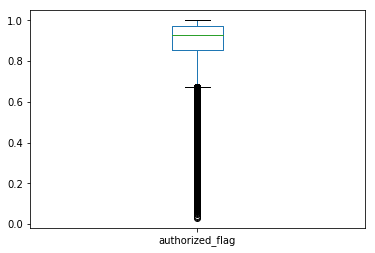

In [112]:
history_authorized_ratio_by_card_id.plot(kind='box');plt.show()

### `card_id` 변수
* 출현빈도수 = 누적결제건수
  * 평균 누적결제건수 89회 (표준편차 105)
  * 최대값 5582회로, 최상위로 갈 수록 편차가 더 커지는 것으로 판단됨
* 누적결제건수는 전체의 75%가 111회 이하에 분포하고 있음
  * 누적결제건수가 111회를 초과하는 카드 id의 숫자는 80,746개 (상위25%)
  
#### `card_id` 총 unique value는 3만 건 이상으로, 카테고리 변수로 활용하기에 부적합
* 그러나, `card_id`에 대응되는 누적결제건수를 numerical 변수로 치환하여 사용할 수 있을 것으로 보임.

In [99]:
# 누적결제건수 상위 10개 card_id
history['card_id'].value_counts()[:10]

C_ID_3d3dfdc692    5582
C_ID_0cd2ce025c    2912
C_ID_cc3d4cd4e3    2143
C_ID_5ccc07beb9    2066
C_ID_5ea401d358    1786
C_ID_9f81506906    1665
C_ID_6ae9f40da5    1665
C_ID_272aa0597a    1647
C_ID_9f63809b99    1634
C_ID_80c1c711c9    1593
Name: card_id, dtype: int64

In [98]:
len(history['card_id'].value_counts()[history['card_id'].value_counts() > 111])

80746

In [97]:
history['card_id'].value_counts().describe()

count    325540.000000
mean         89.427907
std         105.279414
min           2.000000
25%          26.000000
50%          55.000000
75%         111.000000
max        5582.000000
Name: card_id, dtype: float64

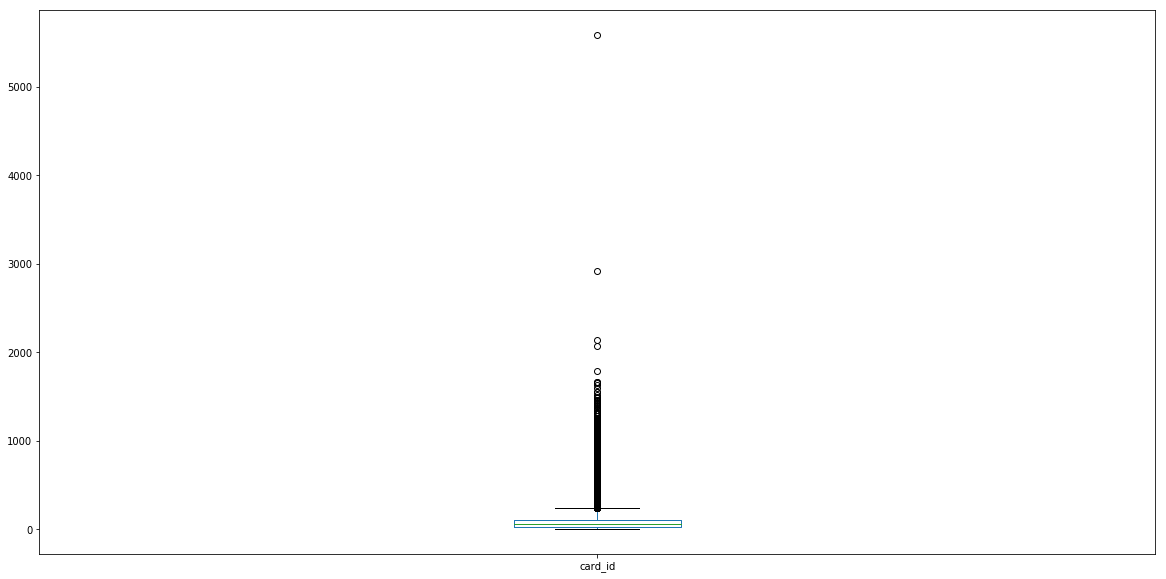

In [96]:
plt.figure(figsize=(20, 10))
history['card_id'].value_counts().plot(kind='box');plt.show()

### `installments` 변수
* `installments`는 installment 형태의 구매횟수 합을 나타내며, installment는 일종의 리스 구매
  * 선호 구매형태에 대한 정보로 활용 가능할 것으로 보임.
* -1, 999의 의미 파악 필요
  * -1은 환불의 의미인지, 아니면 -1와 999가 null과 동일한 의미인지

In [78]:
history['installments'].unique()

array([  0,   1,   5,   3,   4,   2,  -1,  10,   6,  12,   8,   7,   9,
        11, 999])

In [90]:
history['installments'].value_counts() / (history.size/len(history.columns))

 0      0.529388
 1      0.401119
 2      0.022891
 3      0.018487
 4      0.006167
-1      0.006120
 6      0.004556
 10     0.004082
 5      0.003988
 12     0.001891
 8      0.000703
 7      0.000375
 9      0.000198
 11     0.000029
 999    0.000006
Name: installments, dtype: float64

In [124]:
# 'installments' 칼럼 값이 -1 또는 999인 인덱스를 저장
# 총 178,347개 샘플이 installments 이상값을 가지고 있음.
strange_values_indices_minus1 = history['installments'][history['installments']==-1].index
strange_values_indices_999 = history['installments'][history['installments']==999].index

In [125]:
# 전체 history 데이터셋에서 해당 인덱스의 전체 칼럼을 출력.
history.loc[strange_values_indices_minus1]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
885,0,C_ID_fc8e41b9cf,251,N,-1,NaN,34,M_ID_c4f5972059,-1,-0.297615,2018-01-23 12:05:13,3.0,8,38
914,1,C_ID_fc8e41b9cf,251,N,-1,NaN,391,M_ID_bc5663de31,0,-0.393785,2018-02-21 07:24:59,3.0,8,7
936,1,C_ID_fc8e41b9cf,251,N,-1,NaN,307,M_ID_0f437c5559,-3,-0.475694,2017-11-13 00:00:00,3.0,8,19
941,1,C_ID_fc8e41b9cf,170,N,-1,NaN,222,M_ID_b7441bb10f,-1,-0.551563,2018-01-09 14:15:12,3.0,8,21
965,1,C_ID_fc8e41b9cf,251,N,-1,NaN,514,M_ID_1dd8347bcb,-1,-0.114893,2018-01-23 14:04:39,3.0,8,9
992,1,C_ID_fc8e41b9cf,251,N,-1,NaN,414,M_ID_d12eaa9bd7,-3,0.421809,2017-11-27 00:00:00,3.0,8,29
1003,1,C_ID_fc8e41b9cf,251,N,-1,NaN,367,M_ID_b39aa08d22,-2,-0.538791,2017-12-05 11:32:24,3.0,8,16
1031,1,C_ID_fc8e41b9cf,170,N,-1,NaN,422,M_ID_944c5bc932,-1,-0.611669,2018-01-06 10:40:46,3.0,8,27
1035,1,C_ID_fc8e41b9cf,170,N,-1,NaN,506,M_ID_4838a2855e,-2,-0.521510,2017-12-06 10:58:34,3.0,8,30
2329,1,C_ID_058b254a5b,233,N,-1,NaN,68,M_ID_a225855c6f,-2,-0.581616,2017-12-16 10:06:39,1.0,9,27


In [126]:
history.loc[strange_values_indices_999]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
227606,0,C_ID_8b04d4734e,210,N,999,C,806,M_ID_0155450c84,-11,6.237415,2017-03-28 19:40:50,1.0,16,9
466436,0,C_ID_7670e569a0,333,N,999,C,813,M_ID_c9526f2dd3,-10,-0.443673,2017-04-12 21:06:28,5.0,21,29
759501,0,C_ID_652976a4bb,19,N,999,C,356,M_ID_2570628257,-8,0.469038,2017-06-05 09:22:18,1.0,9,21
1182532,0,C_ID_24fb1a2959,331,N,999,C,117,M_ID_67a62f2671,-3,0.208778,2017-11-05 01:29:18,1.0,16,2
1198327,0,C_ID_3742a35e45,333,N,999,C,307,M_ID_5f46ec7f98,-8,-0.521510,2017-05-01 11:17:28,5.0,21,19
1221217,0,C_ID_ba84d050f5,19,N,999,C,884,M_ID_8e7a785122,-8,-0.296127,2017-06-25 16:09:55,1.0,9,27
1368209,0,C_ID_5b6278eb25,69,N,999,C,683,M_ID_f86439cec0,-6,-0.674179,2017-08-23 12:39:48,1.0,9,34
1682455,0,C_ID_51ab074d19,69,N,999,C,412,M_ID_dfc0be4604,-5,-0.100768,2017-09-15 17:42:57,1.0,9,18
1767608,0,C_ID_9cea123f42,181,N,999,C,90,M_ID_596749cc5a,0,-0.318652,2018-02-23 17:29:00,5.0,5,22
2063505,0,C_ID_0a3724504a,279,N,999,C,667,M_ID_45bfdc72e8,-4,-0.259147,2017-10-13 18:46:21,1.0,9,21


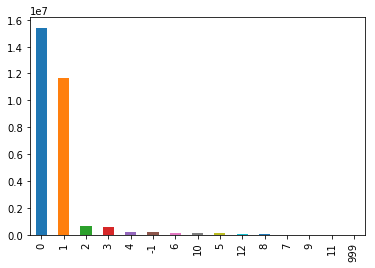

In [81]:
history['installments'].value_counts().plot(kind='bar');plt.show()

In [61]:
# hisotry 데이터셋 개별 변수 탐색.

In [62]:
history['authorized_flag'].unique()

array(['Y', 'N'], dtype=object)

In [ ]:
history['']

In [13]:
merchants = pd.read_csv('data/merchants.csv')

In [17]:
merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

In [19]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [14]:
new_merchants = pd.read_csv('data/new_merchant_transactions.csv')

In [18]:
new_merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB
